In [13]:
import os
import errno
import argparse
import sys
import pickle
import json 

import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

from data_utils import load_CIFAR10_data, load_CIFAR100_data, generate_partial_data, generate_bal_private_data, load_FEMNIST_data, load_MNIST_data
from FedMD import FedMD
from Neural_Networks import train_models, cnn_2layer_fc_model, cnn_3layer_fc_model

import numpy as np
from tensorflow.keras.models import clone_model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from utility import * 
from data_utils import generate_alignment_data
from Neural_Networks import remove_last_layer

## Configurations

In [14]:
private_dataset_name = 'CIFAR100' # 'CIFAR10', 'CIFAR100', 'FEMNIST', 'MNIST
if private_dataset_name in ["CIFAR10", "CIFAR100"]:
    public_dataset_name = 'CIFAR10' if private_dataset_name == 'CIFAR100' else 'CIFAR100'
else : 
    public_dataset_name = 'MNIST' if private_dataset_name == 'FEMNIST' else 'FEMNIST'

print("private dataset: {0}".format(private_dataset_name))
print("public dataset: {0}".format(public_dataset_name))

CANDIDATE_MODELS = {"2_layer_CNN": cnn_2layer_fc_model, 
                    "3_layer_CNN": cnn_3layer_fc_model} 

if private_dataset_name in ["CIFAR10", "CIFAR100"]:
    conf_file = os.path.abspath("conf/CIFAR_balance_conf.json")
else : 
    conf_file = os.path.abspath("conf/EMNIST_balance_conf.json")
with open(conf_file, "r") as f:
    conf_dict = json.load(f) 
    
    #n_classes = conf_dict["n_classes"]
    model_config = conf_dict["models"]
    pre_train_params = conf_dict["pre_train_params"]
    model_saved_dir = conf_dict["model_saved_dir"]
    model_saved_names = conf_dict["model_saved_names"]
    is_early_stopping = conf_dict["early_stopping"]
    public_classes = conf_dict["public_classes"]
    private_classes = conf_dict["private_classes"]
    n_classes = len(public_classes) + len(private_classes)
    
    emnist_data_dir = conf_dict["EMNIST_dir"]    
    N_parties = conf_dict["N_parties"]
    N_samples_per_class = conf_dict["N_samples_per_class"]
    
    N_rounds = conf_dict["N_rounds"]
    N_alignment = conf_dict["N_alignment"]
    N_private_training_round = conf_dict["N_private_training_round"]
    private_training_batchsize = conf_dict["private_training_batchsize"]
    N_logits_matching_round = conf_dict["N_logits_matching_round"]
    logits_matching_batchsize = conf_dict["logits_matching_batchsize"]
    aug = conf_dict["aug"]
    compress = conf_dict["compress"]
    select = conf_dict["select"]
    algorithm = conf_dict["algorithm"]
    
    result_save_dir = conf_dict["result_save_dir"]

del conf_dict, conf_file

private dataset: CIFAR100
public dataset: CIFAR10


## Load data 


In [15]:

data_load_functions = {
    "MNIST": load_MNIST_data,
    "FEMNIST": load_FEMNIST_data,
    "CIFAR10": load_CIFAR10_data,
    "CIFAR100": load_CIFAR100_data,
}


X_train_public, y_train_public, X_test_public, y_test_public \
= data_load_functions[public_dataset_name](standarized = True, verbose = True)

public_dataset = {"X": X_train_public, "y": y_train_public}

X_train_private, y_train_private, X_test_private, y_test_private \
= data_load_functions[private_dataset_name](standarized = True, verbose = True)


private_classes = np.unique(y_train_private)

X_train_private, y_train_private \
= generate_partial_data(X = X_train_private, y= y_train_private,
                        class_in_use = private_classes, 
                        verbose = True)
X_test_private, y_test_private \
= generate_partial_data(X = X_test_private, y= y_test_private,
                        class_in_use = private_classes, 
                        verbose = True)


print("="*60)
#generate private data
private_data, total_private_data\
=generate_bal_private_data(X_train_private, y_train_private,      
                            N_parties = N_parties,           
                            classes_in_use = private_classes, 
                            N_samples_per_class = N_samples_per_class, 
                            data_overlap = False)


print("="*60)
X_tmp, y_tmp = generate_partial_data(X = X_test_private, y= y_test_private,
                                        class_in_use = private_classes, 
                                        verbose = True)
                                        
for i in range(N_parties):
    private_data[i]['y'] = tf.keras.utils.to_categorical(private_data[i]['y'], len(private_classes))
y_tmp = tf.keras.utils.to_categorical(y_tmp, len(private_classes))
    
private_test_data = {"X": X_tmp, "y": y_tmp}

del X_tmp, y_tmp

parties = []
if model_saved_dir is None:
    for i, item in enumerate(model_config):
        model_name = item["model_type"]
        model_params = item["params"]
        tmp = CANDIDATE_MODELS[model_name](n_classes=n_classes, 
                                            input_shape=(32,32,3),
                                            **model_params)
        print("model {0} : {1}".format(i, model_saved_names[i]))
        # print(tmp.summary())
        parties.append(tmp)


X_train shape : (50000, 32, 32, 3)
X_test shape : (10000, 32, 32, 3)
y_train shape : (50000,)
y_test shape : (10000,)
X_train shape : (50000, 32, 32, 3)
X_test shape : (10000, 32, 32, 3)
y_train shape : (50000,)
y_test shape : (10000,)
model 0 : CNN_128_256
model 1 : CNN_128_384
model 2 : CNN_128_512
model 3 : CNN_256_256
model 4 : CNN_256_512
model 5 : CNN_64_128_256
model 6 : CNN_64_128_192
model 7 : CNN_128_192_256
model 8 : CNN_128_128_128
model 9 : CNN_128_128_192


# Save

In [16]:
my_data_dir = '../fl_data/my_data'
if not os.path.exists(my_data_dir):  
    os.mkdir(my_data_dir)

dataset_dir = os.path.join(my_data_dir, private_dataset_name)
if not os.path.exists(dataset_dir):
    os.mkdir(dataset_dir)
for i, d in enumerate(private_data) : 
    client_dir = os.path.join(dataset_dir, str(i))
    if not os.path.exists(client_dir):
        os.mkdir(client_dir)
    np.save(os.path.join(client_dir, 'X'), d['X'])
    np.save(os.path.join(client_dir, 'y'), d['y'])

alignment_dir = os.path.join(dataset_dir, 'alignment')
if not os.path.exists(alignment_dir):
    os.mkdir(alignment_dir)
public_classes = np.unique(y_train_public)
for c in public_classes:
    X_c = X_train_public[y_train_public == c]
    np.save(os.path.join(alignment_dir, 'X_align_{}'.format(c)), X_c)

test_dir = os.path.join(my_data_dir, private_dataset_name, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
for c in private_classes:
    X_test_private_c = X_test_private[y_test_private == c]
    np.save(os.path.join(test_dir, 'X_{}'.format(c)), X_test_private_c)


In [17]:
private_data[0]['y'].shape

(500, 100)

# Training

In [ ]:
new_total_private_data = {}
new_total_private_data['X'] = np.concatenate([p['X'] for p in private_data ], axis = 0)
new_total_private_data['y'] = np.concatenate([p['y'] for p in private_data ], axis = 0)

print(private_data[0]['X'].shape, total_private_data['X'].shape, new_total_private_data['X'].shape)

In [ ]:
print("size of public data:", size_of(public_dataset['X']))
print("size of logits:", size_of(public_dataset['y']))
print("size of total private data:", size_of(total_private_data['X']))
print("size of private data:", size_of(private_data[0]['X']))
print("size of model:", size_of(parties[0]))
print("number of parties:", len(parties))

size_of(public_dataset['y']), size_of(parties[0]), len(parties), size_of(public_dataset['X'])

In [ ]:
input_shape = private_data[0]["X"].shape[1:]
# [0.5483333468437195, 0.5421666502952576, 0.6263333559036255, 0.4596666693687439, 0.5808333158493042, 0.6393333077430725, 0.6313333511352539, 0.5663333535194397, 0.5171666741371155, 0.503333330154419]

local_accuracies = [] 
for i in range(len(private_data)):

    tf.keras.backend.clear_session()
    item = model_config[0]
    model_name = item["model_type"]
    model_params = item["params"]
    model_ub = CANDIDATE_MODELS[model_name](n_classes=n_classes, 
                                        input_shape=input_shape,
                                        **model_params)
    model_ub.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
                        loss = "sparse_categorical_crossentropy", 
                        metrics = ["accuracy"])
    ub_history = model_ub.fit(private_data[i]['X'], private_data[i]['y'],
                    batch_size = 30, epochs = 30, shuffle=True, verbose = True, 
                    validation_data = [private_test_data["X"], private_test_data["y"]],
                    callbacks=[EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=7, restore_best_weights=True)])

    local_accuracies.append(ub_history.history["val_accuracy"])
    print("final accuracy:", ub_history.history["val_accuracy"][-1])


In [ ]:
np.mean([acc[-1] for acc in local_accuracies])

average: 0.011999999999999999


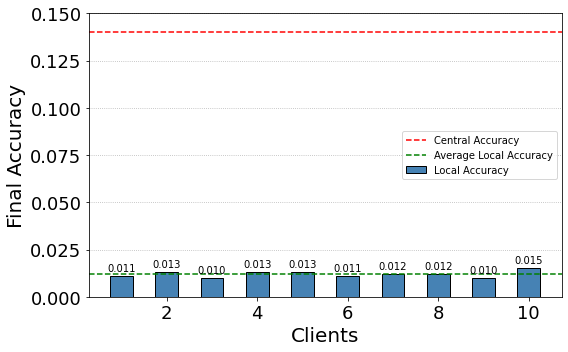

In [14]:
import matplotlib.pyplot as plt

# Data for the bar plot
# accuracies = [0.5483333468437195, 0.5421666502952576, 0.6263333559036255, 0.4596666693687439, 0.5808333158493042, 0.6393333077430725, 0.6313333511352539, 0.5663333535194397, 0.5171666741371155, 0.503333330154419]
accuracies = [0.011, 0.013, 0.010, 0.013, 0.013, 0.011, 0.012, 0.012, 0.010, 0.015]
# accuracies = [acc[-1] for acc in local_accuracies]
# Clients for the x-axis (assuming one accuracy value per client)
clients = range(1, len(accuracies) + 1)

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the bar chart with custom colors, edgecolor, and width
bars = ax.bar(clients, accuracies, color='steelblue', edgecolor='black', width=0.5, label = 'Local Accuracy')

# Add values on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', fontsize=10)

# Set x and y axis labels and title
ax.set_xlabel('Clients', fontsize = 20)
ax.set_ylabel('Final Accuracy', fontsize = 20)
# ax.set_title('Accuracies of Clients\' Local Training',  fontsize = 20)

# Add a horizontal line at accuracy 70 to mark it as the central accuracy
# central_avg_acc = np.mean([acc[-1] for acc in central_trials])
central_avg_acc = 0.7
central_avg_acc = 0.14
ax.axhline(y=central_avg_acc, color='red', linestyle='--', label='Central Accuracy')

# Add a horizontal line for the average accuracy local 
ax.axhline(y=sum(accuracies)/len(accuracies), color='green', linestyle='--', label='Average Local Accuracy')

print("average:", sum(accuracies)/len(accuracies))
# Add a grid to the plot
ax.grid(axis='y', linestyle='dotted')
ax.tick_params(axis='both', labelsize=18)

# Set the y-limit if needed
ax.set_ylim([0, 0.15])  
# Adjust the layout to avoid cutting off labels
plt.tight_layout()

# Add a legend with position right bottom
plt.legend(loc='best')

# Save the plot as a high-quality PDF
plt.savefig('local_central_cifar.pdf', dpi=300)

# Show the plot
plt.show()


In [ ]:
    
central_trials = [] 
for i in range(5) : 
    tf.keras.backend.clear_session()
    input_shape = private_data[0]["X"].shape[1:]

    cbs = [EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=7, restore_best_weights=True)]
    cbs = [] 

    item = model_config[0]
    model_name = item["model_type"]
    model_params = item["params"]
    model_ub = CANDIDATE_MODELS[model_name](n_classes=n_classes, 
                                        input_shape=input_shape,
                                        **model_params)
    model_ub.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
                        loss = "sparse_categorical_crossentropy", 
                        metrics = ["accuracy"])
    print("shpae of private data:", private_data[0]["X"].shape)
    ub_history = model_ub.fit(new_total_private_data['X'], new_total_private_data['y'],
                    batch_size = 30, epochs = 40, shuffle=True, verbose = True, 
                    validation_data = [private_test_data["X"], private_test_data["y"]],
                    callbacks=[cbs])

    central_trials.append(ub_history.history["val_accuracy"])
    print("final accuracy:", ub_history.history["val_accuracy"][-1])


In [ ]:
np.mean([acc[-1] for acc in central_trials]), [acc[-1] for acc in central_trials]

In [ ]:
np.mean(local_trials), np.std(local_trials)

In [ ]:
np.mean(central_trials), np.std(central_trials), central_trials